In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import math

def get_points(mask):
    points = []
    n, m = mask.shape
    box_size = max(n, m)
    v_repeat = math.ceil(box_size / n)
    h_repeat = math.ceil(box_size / m)
    box  = np.tile(mask, (v_repeat, h_repeat))
    box = box[:box_size, :box_size]

    for i in range(box_size):
        for j in range(box_size):
            if box[i, j]:
                points.append([i, j])
    points = np.array(points)
    return points, box_size

# MAR_mask, MCAR_mask, MNAR_mask = gen_data(df.copy(), 0.1)
# MAR_points,box_size = get_points(MAR_mask)
# MCAR_points,_ = get_points(MCAR_mask)
# MNAR_points,_ = get_points(MNAR_mask)
# df = pd.read_csv("dataset/PUE.csv")
# # select the numeric columns
# df = df.select_dtypes(include=[np.number])

# # plt.figure(figsize=(12, 4))
# # plt.subplot(131)
# # plt.scatter(MAR_points[:, 0], MAR_points[:, 1], s=1)
# # plt.title("MAR")
# # plt.subplot(132)
# # plt.scatter(MCAR_points[:, 0], MCAR_points[:, 1], s=1)
# # plt.title("MCAR")
# # plt.subplot(133)
# # plt.scatter(MNAR_points[:, 0], MNAR_points[:, 1], s=1)
# # plt.title("MNAR")
# # plt.show()

In [3]:
def cal_dis(points, box_size):
    dis = []
    n = points.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            posi = points[i]
            posj = points[j]
            dr = posj - posi
            dr = dr - box_size * np.floor(dr / box_size + 0.5)

            dist = np.sqrt(np.sum(dr**2))
            dis.append(dist)
    return np.array(dis)

In [4]:
def cal_dis_vec(points, box_size):
    points = np.asarray(points, dtype=np.float16)
    box_size = np.float16(box_size)
    
    n = points.shape[0]
    
    # Calculate all pairwise differences
    diff = points[np.newaxis, :, :] - points[:, np.newaxis, :]
    
    # Apply minimum image convention
    diff -= box_size * np.floor(diff / box_size + 0.5)
    
    # Calculate distances
    dist = np.sqrt(np.sum(diff**2, axis=-1))
    
    # Get upper triangular indices excluding diagonal
    i_upper, j_upper = np.triu_indices(n, k=1)
    upper_triangular = dist[i_upper, j_upper]
    
    # Get lower triangular indices excluding diagonal
    i_lower, j_lower = np.tril_indices(n, k=-1)
    lower_triangular = dist[i_lower, j_lower]

    all_distances = np.concatenate((upper_triangular, lower_triangular))

    return all_distances

In [5]:
def hist_dis(dists, max_dist, bin_size):
    bins = np.arange(0, max_dist + bin_size, bin_size)
    hist, bin_edge = np.histogram(dists,bins=bins)
    return hist, bin_edge

def plot_hist(hist, bin_edge):
    bin_center = (bin_edge[:-1] + bin_edge[1:]) / 2.0
    plt.plot(bin_center, hist, marker="o")
    plt.xlabel("$r$")
    plt.ylabel("N(r)")
    plt.show()

In [6]:
import seaborn as sns

sns.set_theme(style="whitegrid",font="Times New Roman",font_scale=1.5)

def plot_rdf(gofr, bin_center, save=False, save_path=None):
    plt.plot(bin_center, gofr, marker="o")
    plt.xlabel("$r$")
    plt.ylabel("g(r)")
    if save and save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

def get_gofr(hist,bin_edges,num_particles, box_size):
    rho = num_particles/ box_size / box_size
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2.0
    dr = bin_edges[1]-bin_edges[0]
    denominator = 2.*np.pi*bin_centers*dr*rho*num_particles
    gofr = hist/denominator
    
    return gofr, bin_centers

In [24]:
mask = [[False,True]*50]*100
mask = np.array(mask)
points, box_size = get_points(mask)
print(points.shape)
print(box_size)

(5000, 2)
100


In [49]:
def plot_points(points):
    plt.scatter(points[:, 0], points[:, 1], s=1)
    plt.show()

def rdf(mask):
    points, box_size = get_points(mask)
    plot_points(points)
    dis = cal_dis_vec(points, box_size)
    bin_size = 1
    num_particles = points.shape[0]
    hist, bin_edge = hist_dis(dis, box_size/2, 1)
    gofr, bin_centers = get_gofr(hist, bin_edge, num_particles, box_size)
    return gofr, bin_centers

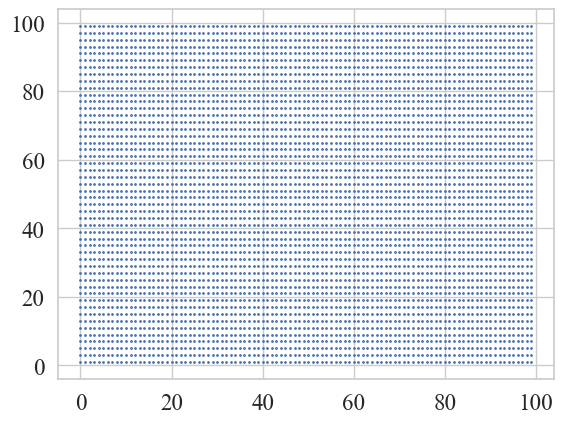

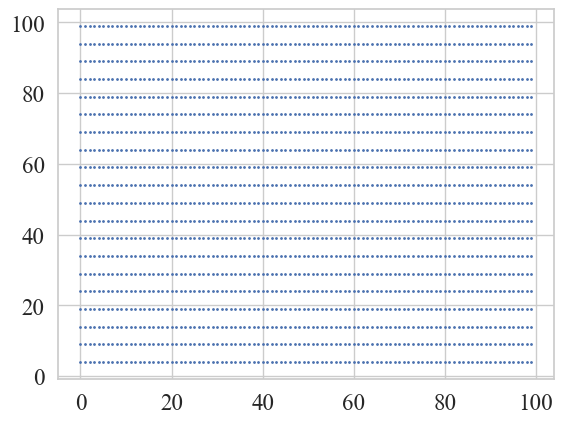

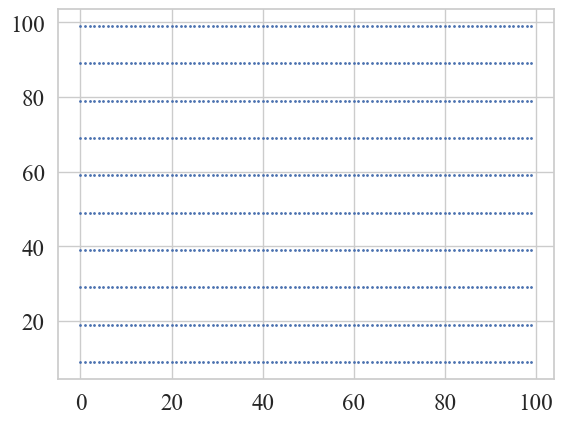

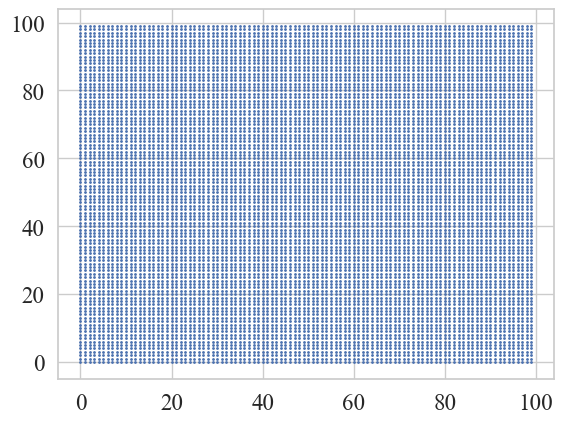

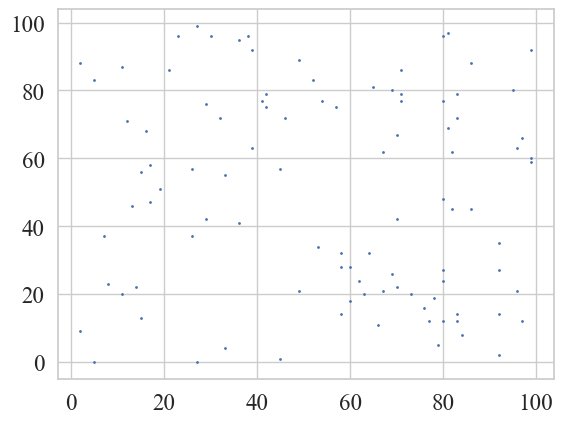

In [56]:
mask = [[False,True]*50]*100 # 0.5
mask = np.array(mask)
gofr1, bin_centers1 = rdf(mask)

mask = [[False,False,False,False,True]*20]*100 # 0.2
mask = np.array(mask)
gofr2, bin_centers2 = rdf(mask)

mask = [[False,False,False,False,False,False,False,False,False,True]*10]*100 # 0.1
mask = np.array(mask)
gofr3, bin_centers3 = rdf(mask)

mask = [[True]*100]*100 # 1.0
mask = np.array(mask)
gofr4, bin_centers4 = rdf(mask)

mask = [[False]*100]*100 # 0.0
# random pick 100 points set to True
mask = np.array(mask)
points = np.random.randint(0, 100, (100, 2))
for point in points:
    mask[point[0], point[1]] = True
gofr5, bin_centers5 = rdf(mask)

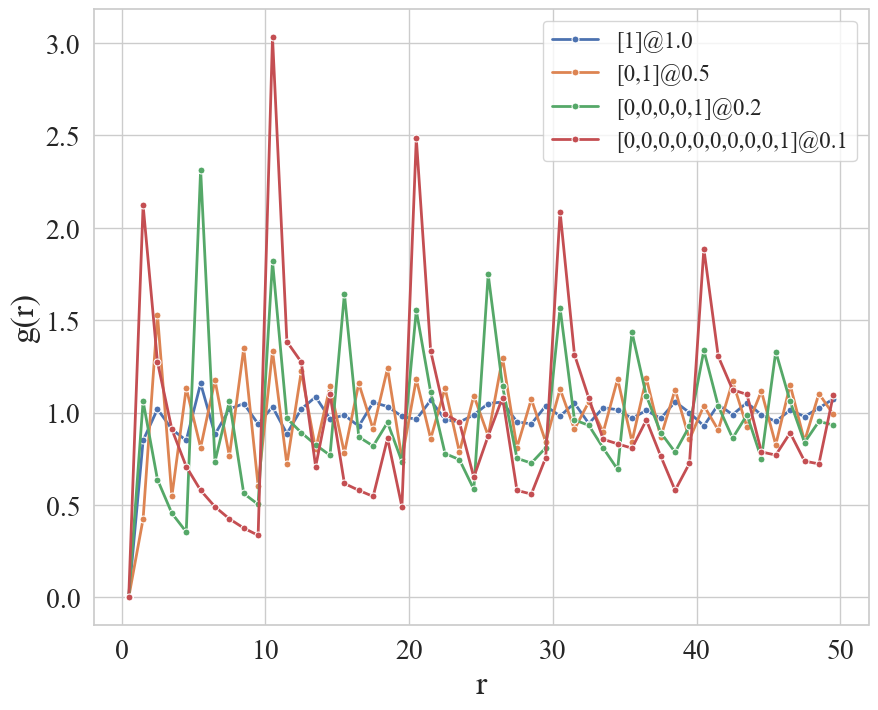

In [61]:
import seaborn as sns
sns.set_theme(style="whitegrid",font="Times New Roman",font_scale=1.5)

fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(x=bin_centers4, y=gofr4, ax=ax,  marker="o",label="[1]@1.0",markersize=5,linewidth=2)
sns.lineplot(x=bin_centers1, y=gofr1, ax=ax, marker="o",label="[0,1]@0.5",markersize=5,linewidth=2)
sns.lineplot(x=bin_centers2, y=gofr2, ax=ax,  marker="o",label="[0,0,0,0,1]@0.2",markersize=5,linewidth=2)
sns.lineplot(x=bin_centers3, y=gofr3, ax=ax, marker="o",label="[0,0,0,0,0,0,0,0,0,1]@0.1",markersize=5,linewidth=2)

# sns.lineplot(x=bin_centers5, y=gofr5, ax=ax, color="#F35FF3", marker="o",label="Random@0.01",markersize=5,linewidth=2)
ax.set_xlabel("r",fontsize=24)
ax.set_ylabel("g(r)",fontsize=24)
ax.tick_params(labelsize=20)
plt.show()